In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Calculate the date 1 year ago from today
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [13]:
last_year = dt.date(2017,8,23) - dt.timedelta(days=365) 
last_year

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)

# Sort the dataframe by date
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
prcp_df_sorted = prcp_df.sort_values('date', ascending=True)


# Set index to date for dataframe
prcp_df_sorted = prcp_df_sorted.set_index('date')

# Rename column for precipitation
prcp_df_sorted.rename(columns = {'prcp':'precipitation'}, inplace=True)
prcp_df_sorted.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


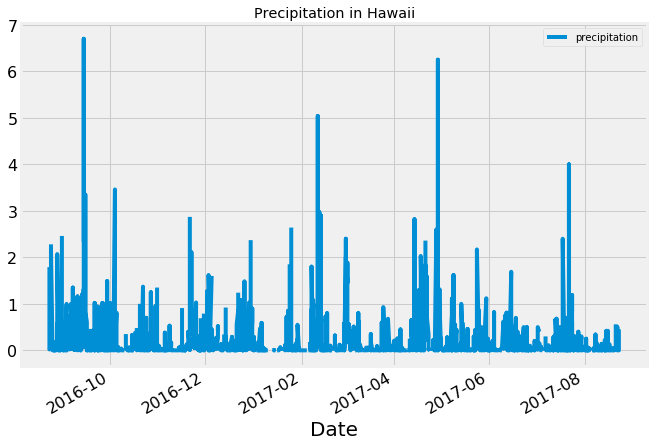

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df_sorted.plot(figsize=(10, 7),                                               
               use_index=True, 
               title='Precipitation in Hawaii', 
               legend=True,
               fontsize=16,
               grid=True,
              )

plt.xlabel('Date', fontsize=20)
plt.show()


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df_sorted.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# How many stations are available in this dataset?

station_num = session.query(Station.id).count()
station_num

9

In [18]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tem_lowest = session.query(func.min(Measurement.tobs)).all()
tem_highest = session.query(func.max(Measurement.tobs)).all()
tem_avg = session.query(func.avg(Measurement.tobs)).all()
print(tem_lowest,tem_highest,tem_avg)

[(53.0,)] [(87.0,)] [(73.09795396419437,)]


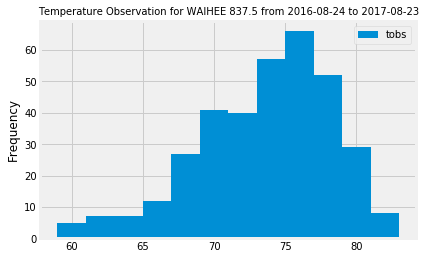

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").filter(Measurement.station == 'USC00519281').all()
tobs_data_df = pd.DataFrame(tobs_data)

tem = tobs_data_df['tobs']

plt.hist(tem, bins=12)
plt.title("Temperature Observation for WAIHEE 837.5 from 2016-08-24 to 2017-08-23", fontsize=10)
plt.ylabel('Frequency', fontsize=12)
labels = ['tobs']
plt.legend(labels)
plt.show()

In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = dt.date(2018, 7, 5)
trip_end_date = dt.date(2018, 7, 18)
last_year = dt.timedelta(days=365)
temp = (calc_temps((trip_start_date-last_year), (trip_end_date-last_year)))
print(temp)

[(69.0, 78.1978021978022, 83.0)]


Text(0,0.5,'Temp (F)')

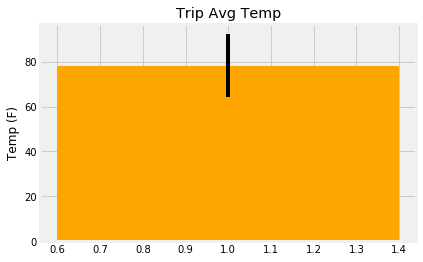

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmax = temp[0][2]
tmin = temp[0][0]
avg = temp[0][1]
error_bar = tmax - tmin
plt.bar(1, avg, yerr=error_bar, color= 'orange')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")


In [24]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start_date = dt.date(2018, 7, 5)
trip_end_date = dt.date(2018, 7, 18)
last_year = dt.timedelta(days=365)
last_year_start = trip_start_date-last_year
last_year_end = trip_end_date-last_year
results = session.query(Station.name, Station.station, Station.latitude, Station.longitude, Station.elevation,\
    Measurement.date, func.sum(Measurement.prcp)).filter(Measurement.station == Station.station).\
    filter(Measurement.date >= last_year_start).filter(Measurement.date <= last_year_end).\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
results

[('MANOA LYON ARBO 785.2, HI US',
  'USC00516128',
  21.3331,
  -157.8025,
  152.4,
  '2017-07-18',
  5.16),
 ('WAIHEE 837.5, HI US',
  'USC00519281',
  21.45167,
  -157.84888999999998,
  32.9,
  '2017-07-18',
  1.5400000000000003),
 ('KANEOHE 838.1, HI US',
  'USC00513117',
  21.4234,
  -157.8015,
  14.6,
  '2017-07-18',
  0.7800000000000001),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  21.5213,
  -157.8374,
  7.0,
  '2017-07-18',
  0.67),
 ('WAIKIKI 717.2, HI US',
  'USC00519397',
  21.2716,
  -157.8168,
  3.0,
  '2017-07-18',
  0.19),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  'USC00519523',
  21.33556,
  -157.71139,
  19.5,
  '2017-07-18',
  0.11),
 ('PEARL CITY, HI US',
  'USC00517948',
  21.3934,
  -157.9751,
  11.9,
  '2017-07-18',
  0.0)]

## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_start_date = dt.datetime.strptime("5-7-2017", "%d-%m-%Y")
trip_end_date = dt.datetime.strptime("18-7-2017", "%d-%m-%Y")
# Use the start and end date to create a range of dates
date_range = [trip_start_date + dt.timedelta(days=x) for x in range(0, (trip_end_date-trip_start_date).days)]
# Stip off the year and save a list of %m-%d strings
trip_dates = []
for date in date_range:
    date_list = date.strftime("%y-%m-%d")
    trip_dates.append(date_list)
print(trip_dates)
dates = []
for date in date_range:
    date_list_1 = date.strftime("%m-%d")
    dates.append(date_list_1)
print(dates)    
# Loop through the list of %m-%d strings and calculate the normals for each date
dates_normal = []
for date in dates:
    normal = daily_normals(date)
    dates_normal.append(normal)
dates_normal

['17-07-05', '17-07-06', '17-07-07', '17-07-08', '17-07-09', '17-07-10', '17-07-11', '17-07-12', '17-07-13', '17-07-14', '17-07-15', '17-07-16', '17-07-17']
['07-05', '07-06', '07-07', '07-08', '07-09', '07-10', '07-11', '07-12', '07-13', '07-14', '07-15', '07-16', '07-17']


[[(66.0, 75.0, 81.0)],
 [(69.0, 75.0, 81.0)],
 [(69.0, 74.91071428571429, 82.0)],
 [(69.0, 76.08333333333333, 83.0)],
 [(68.0, 76.19298245614036, 83.0)],
 [(68.0, 75.62068965517241, 82.0)],
 [(70.0, 75.78947368421052, 81.0)],
 [(67.0, 75.96491228070175, 82.0)],
 [(69.0, 76.1896551724138, 81.0)],
 [(61.0, 76.2280701754386, 82.0)],
 [(68.0, 76.2542372881356, 82.0)],
 [(70.0, 76.34482758620689, 83.0)],
 [(70.0, 76.30188679245283, 83.0)]]

In [27]:
dates_normal_list = []
i = 0
for date_normal in dates_normal:
    x = dates_normal[i]
    y = list(x[0])
    dates_normal_list.append(y)
    i += 1
    
trip_daily = pd.DataFrame(dates_normal_list, columns=['tmin','tavg','tmax'])
trip_daily['date'] = trip_dates
trip_daily = trip_daily.set_index('date')
trip_daily

,tmin,tavg,tmax
date,,,
17-07-05,66.0,75.000000,81.0
17-07-06,69.0,75.000000,81.0
17-07-07,69.0,74.910714,82.0
17-07-08,69.0,76.083333,83.0
17-07-09,68.0,76.192982,83.0
17-07-10,68.0,75.620690,82.0
17-07-11,70.0,75.789474,81.0
17-07-12,67.0,75.964912,82.0
17-07-13,69.0,76.189655,81.0


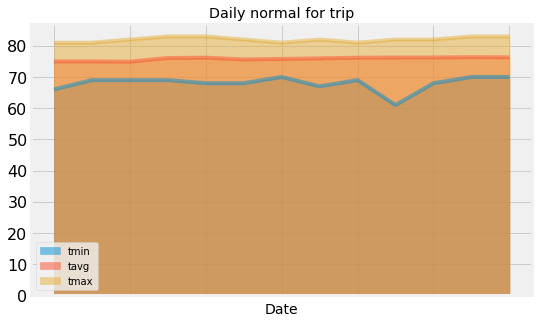

In [28]:
trip_daily.plot(figsize=(8, 5),                                               
                use_index=True, 
                title='Daily normal for trip', 
                legend=True,
                fontsize=16,
                grid=True,
                stacked=False,
                kind='area'
              )
plt.xlabel('Date', fontsize=14)
plt.show()
